* Consider implementing streamlined distance functions using 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html


* Consider implementing area around player with football using
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html


* Consider creating ID of player who performed tackle/is closest to rusher/receiver/QB when an interception/sack/block happens


* If implementing K-Folds, group by play_id

* Implement quiver plot for velocity/acceleration
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html
https://www.tutorialspoint.com/matplotlib/matplotlib_quiver_plot.htm#:~:text=A%20quiver%20plot%20displays%20the,elements%20in%20x%20and%20y.

In [270]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns
import re
from datetime import date, datetime
import glob
import plotly.figure_factory as ff

path = "data"

## Players data cleanup

In [2]:
players = pd.read_csv(path + "/players.csv")

In [3]:
#Convert height from feet-inches to inches

r = re.compile(r"([0-9]+)-([0-9]+)")
def get_inches(el):
    m = r.match(el)
    if m == None:
        return int(el)
    else:
        return int(m.group(1))*12 + int(m.group(2))

players['height'] = players['height'].apply(get_inches)

#pd.unique(players['height'])

In [4]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell


In [5]:
#Create new column for age

def calculate_age(born):
    r1 = re.compile(r"([0-9]+)-([0-9]+)-([0-9]+)")
    r2 = re.compile(r"([0-9]+)/([0-9]+)/([0-9]+)")
    today = date.today()
    m = r1.match(born)
    if m == None:
        m = r2.match(born)
    if len(m.group(1)) == 4:
        yr = m.group(1)
        mnth = m.group(2)
        day = m.group(3)
    else:
        yr = m.group(3)
        mnth = m.group(2)
        day = m.group(1)
    return today.year - int(yr) - ((today.month, today.day) < (int(mnth), int(day)))

players['age_2020'] = players['birthDate'].apply(calculate_age)

#pd.unique(players['age_2020'])

## Games data cleanup

In [6]:
games = pd.read_csv(path + "/games.csv")

In [7]:
games.head()

,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
0,2018090600,09/06/2018,20:20:00,PHI,ATL,1
1,2018090901,09/09/2018,13:00:00,CLE,PIT,1
2,2018090902,09/09/2018,13:00:00,IND,CIN,1
3,2018090903,09/09/2018,13:00:00,MIA,TEN,1
4,2018090900,09/09/2018,13:00:00,BAL,BUF,1


In [8]:
#### How do you account for bye weeks?
# Don't need to--if you're looking at play by play data.
# Alternatively, could look at # of game played per team instead of week #

## Plays data cleanup

In [8]:
plays = pd.read_csv(path + "/plays.csv")

In [9]:
# Add penaltyNumber for plays with multiple penalties

plays['penaltyNumber'] = plays['penaltyCodes'].map(lambda x: int(len(x.split(";"))) if type(x) == str else x)        

## Week data appending

In [10]:
#May not be a bad idea to append the result of a given play to all timestamps of that specific play

#weekdata = glob.glob(os.path.join(path, "*.csv"))

#week = pd.concat((pd.read_csv(f) for f in weekdata if "week" in f))

#Let's just import week1 so that we can move quickly. Later on we can import all the data.s
week1 = pd.read_csv(path + "/week1.csv")

In [12]:
#week.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH


In [11]:
#week1 = pd.read_csv(path + "/week1.csv")
x = week1[(week1['gameId'] == 2018090600)&(week1['nflId'] == 310)&(week1['playId'] == 75)]['x'].values
y = week1[(week1['gameId'] == 2018090600)&(week1['nflId'] == 310)&(week1['playId'] == 75)]['y'].values
t = week1[(week1['gameId'] == 2018090600)&(week1['nflId'] == 310)&(week1['playId'] == 75)]['time'].values
t2 = [float(i[-7:-1]) for i in t]

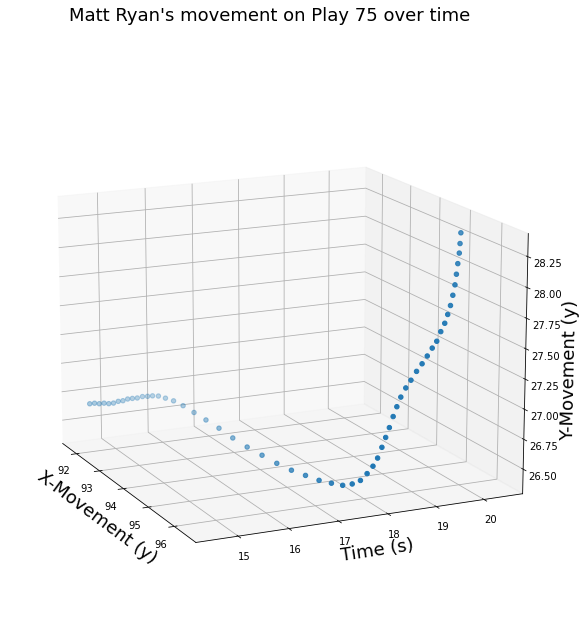

In [17]:
#Matt Ryan's x/y movement on play 75 over time
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x, t2, y, marker='o')

ax.set_xlabel('X-Movement (y)', fontsize=18)
ax.set_ylabel('Time (s)', fontsize=18)
ax.set_zlabel('Y-Movement (y)', fontsize=18)
ax.view_init(15, -25)
fig.suptitle('Matt Ryan\'s movement on Play 75 over time', fontsize=18)
plt.show()

<ipython-input-16-3fe872f70752>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  i_list = np.array(week1[week1['gameId'] == 2018090600][week1['nflId'] == 310][week1['playId'] == 75]['s'].values)
<ipython-input-16-3fe872f70752>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  i_list = np.array(week1[week1['gameId'] == 2018090600][week1['nflId'] == 310][week1['playId'] == 75]['s'].values)


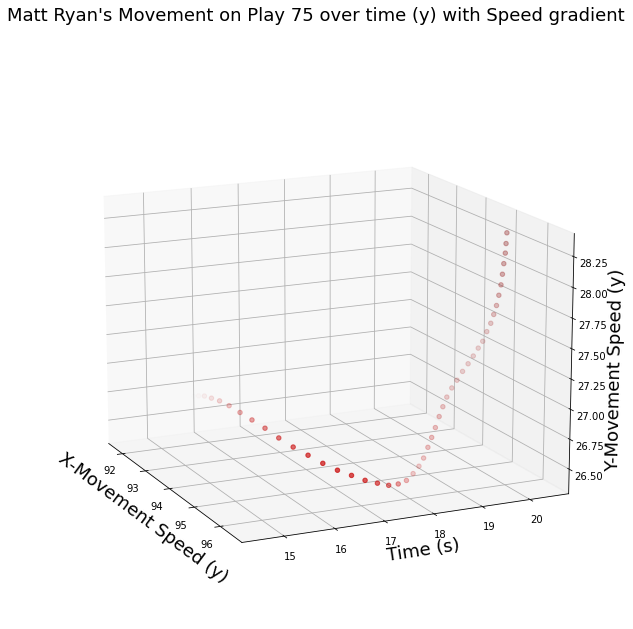

In [16]:
cmap = plt.cm.jet

# get a Nx4 array of RGBA corresponding to zs
# cmap expects values between 0 and 1
y = np.array(y) # if z_list is type `list`
colors = cmap(y / y.max())

# set the alpha values according to i_list
# must satisfy 0 <= i <= 1
i_list = np.array(week1[week1['gameId'] == 2018090600][week1['nflId'] == 310][week1['playId'] == 75]['s'].values)
colors[:,-1] = i_list / i_list.max()

# then plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, t2, y, c=colors)
ax.set_xlabel('X-Movement Speed (y)', fontsize=18)
ax.set_ylabel('Time (s)', fontsize=18)
ax.set_zlabel('Y-Movement Speed (y)', fontsize=18)
ax.view_init(15, -25)
fig.suptitle('Matt Ryan\'s Movement on Play 75 over time (y) with Speed gradient', fontsize=18)
plt.show()

<ipython-input-18-d87676163df4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  i_list = np.array(week1[week1['gameId'] == 2018090600][week1['nflId'] == 310][week1['playId'] == 75]['a'].values)
<ipython-input-18-d87676163df4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  i_list = np.array(week1[week1['gameId'] == 2018090600][week1['nflId'] == 310][week1['playId'] == 75]['a'].values)


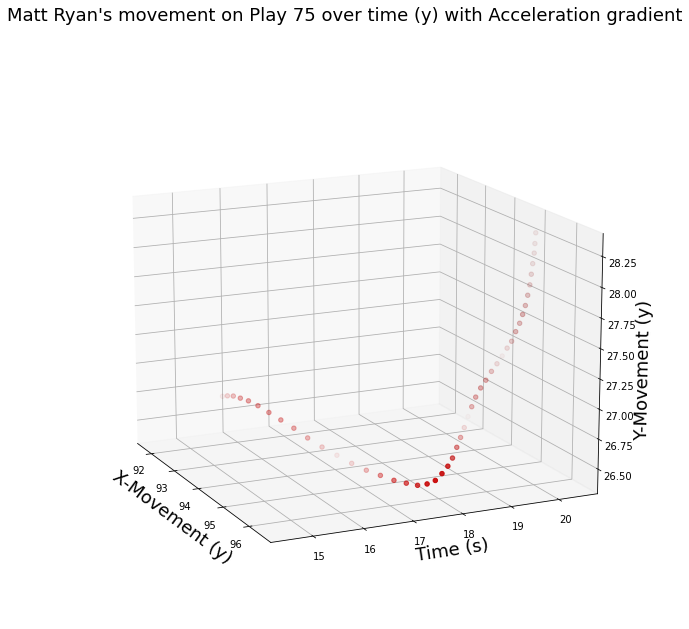

In [18]:
cmap = plt.cm.jet

# get a Nx4 array of RGBA corresponding to zs
# cmap expects values between 0 and 1
y = np.array(y) # if z_list is type `list`
colors = cmap(y / y.max())

# set the alpha values according to i_list
# must satisfy 0 <= i <= 1
i_list = np.array(week1[week1['gameId'] == 2018090600][week1['nflId'] == 310][week1['playId'] == 75]['a'].values)
colors[:,-1] = i_list / i_list.max()

# then plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, t2, y, c=colors)
ax.set_xlabel('X-Movement (y)', fontsize=18)
ax.set_ylabel('Time (s)', fontsize=18)
ax.set_zlabel('Y-Movement (y)', fontsize=18)
ax.view_init(15, -25)
fig.suptitle('Matt Ryan\'s movement on Play 75 over time (y) with Acceleration gradient', fontsize=18)
plt.show()

## EDA

In [19]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,age_2020
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,30
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,31
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,28
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,25
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,27


Text(0, 0.5, 'Frequency')

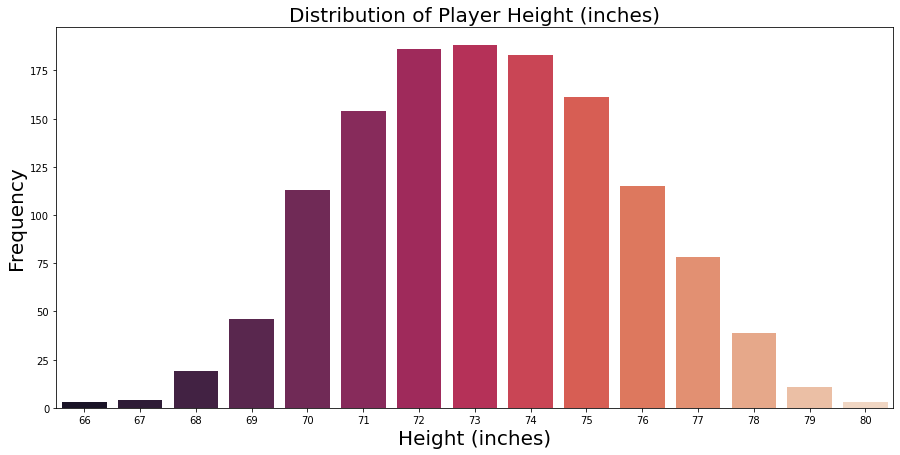

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(x="height", data=players, palette="rocket")
plt.title('Distribution of Player Height (inches)', fontsize = 20)
plt.xlabel('Height (inches)', fontsize = 20)

plt.ylabel('Frequency', fontsize = 20)

/Users/martincopello/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


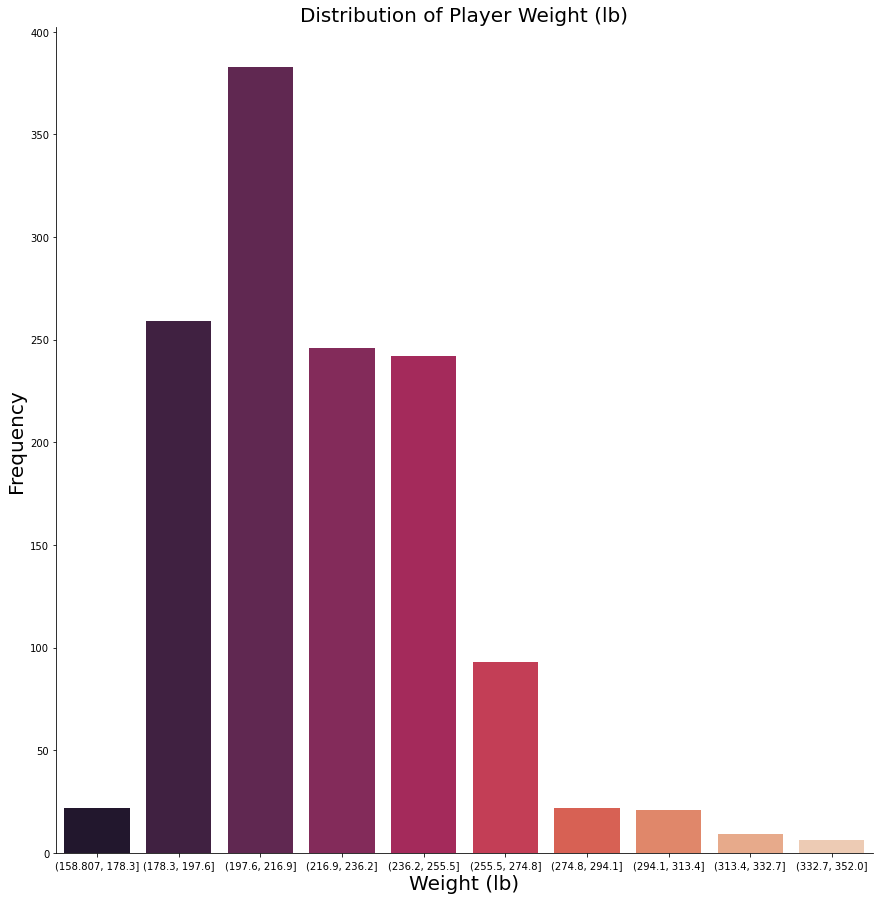

In [21]:
#Let's bin our weight data and plot it 

binweight = pd.cut(players['weight'], 10)
binweight = pd.DataFrame(binweight)
ax = sns.catplot(x = 'weight', data = binweight, kind = 'count', palette = 'rocket', size = 12)
plt.title('Distribution of Player Weight (lb)', fontsize = 20)
plt.xlabel('Weight (lb)', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.show()

In [22]:
counts = players['collegeName'].value_counts().to_dict()
top10coll = players['collegeName'].value_counts()[:10].index.tolist()

counts10 = []
for i in top10coll:
    counts10.append(counts.get(i))
    
df10coll = pd.DataFrame()
df10coll['college'] = top10coll
df10coll['freq'] = counts10

/Users/martincopello/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/martincopello/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


Text(10.049999999999997, 0.5, 'Frequency')

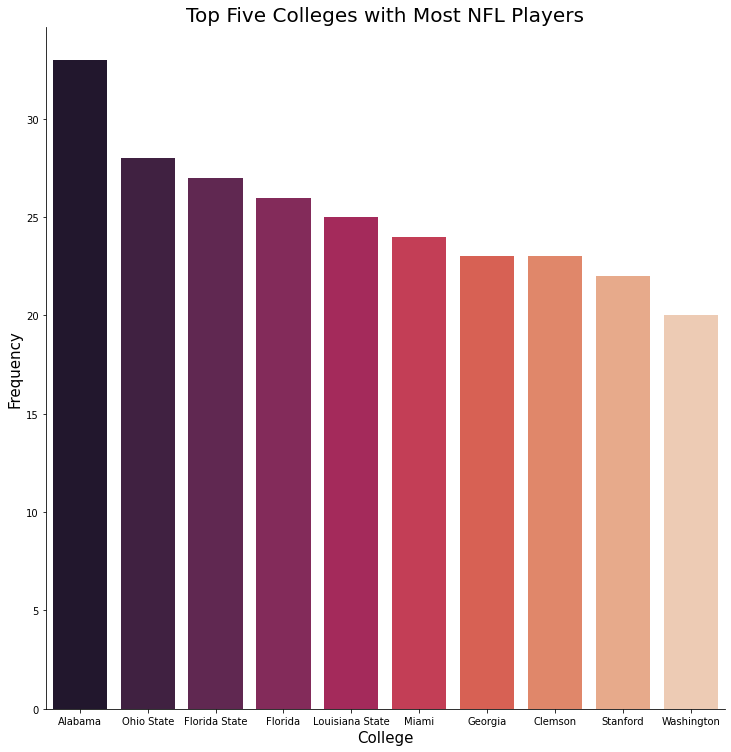

In [23]:
sns.catplot(ax = ax, x='college' , y='freq', kind="bar", data = df10coll, palette = 'rocket', size = 10)
plt.title('Top Five Colleges with Most NFL Players', fontsize = 20)
plt.xlabel('College', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

## Plotting Plays

In [24]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [66]:
def plot_ff(df, gameid, playid, frameid):
    away = df[(df['gameId'] == gameid)&(df['team'] == 'away')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    home = df[(df['gameId'] == gameid)&(df['team'] == 'home')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    ball = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(week1['frameId'] == frameid)]

    fig, ax = create_football_field()
    ax.scatter(x='x', y='y', color='orange', s=30, data = away, label = 'away')
    ax.scatter(x='x', y='y', color='blue', s=30, data = home, label = 'home')
    ax.scatter(x = 'x', y = 'y', color = 'red', s = 30, data = ball, label = 'ball')
    plt.title('Game ' + str(gameid) + ' Play # ' + str(playid) +' at frame ' + str(frameid))
    plt.legend()
    plt.show()

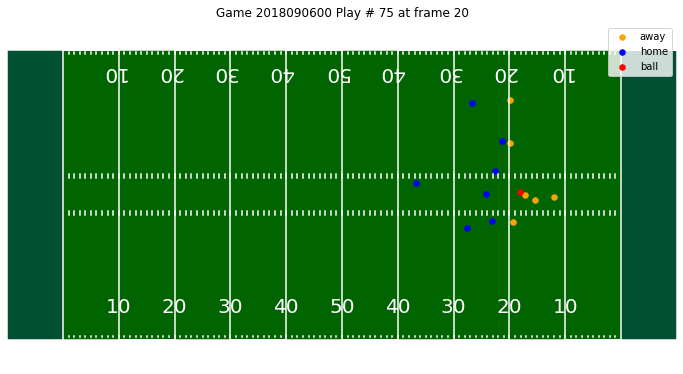

In [67]:
plot_ff(week1, 2018090600, 75, 20)

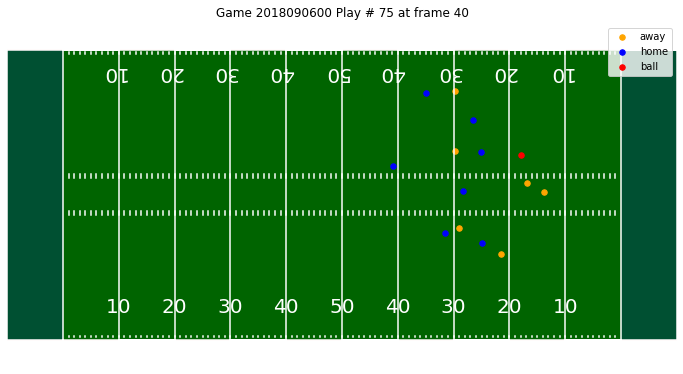

In [27]:
plot_ff(week1, 2018090600, 75, 40)

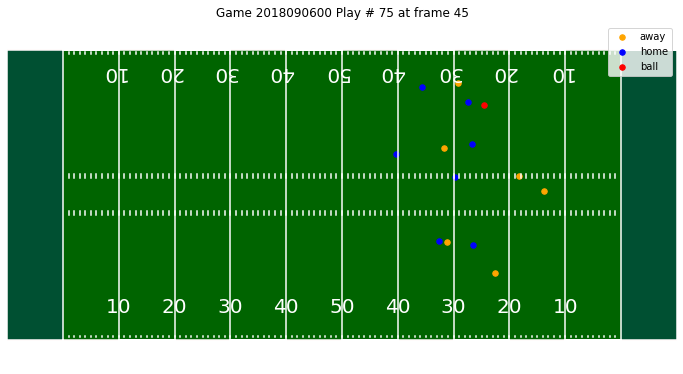

In [28]:
plot_ff(week1, 2018090600, 75, 45)

In [29]:
#May be a good idea to think of how to incorporate these events into our plotting/analysis
week1['event'].unique()

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered', 'handoff',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'pass_shovel', 'line_set', 'shift', 'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown', 'run',
       'touchback', 'penalty_flag', 'penalty_accepted', 'qb_spike',
       'field_goal_blocked'], dtype=object)

## Distances Between Players and Football

In [38]:
#We create function to compute distance
def dist(x1, y1, x2, y2):
    dis = np.sqrt((x2-x1) ** 2 + (y2-y1) ** 2)
    return dis

In [39]:
#Can we create a function that gives us an array of distances to other players?
#Yes. This function will output two lists: the first one includes the relative distance from our player to all his
#other teammates. The second once includes the relative distance from our player to all his oponents on the field
#for a specific game, play, frame, and player.

def player_distances(df, nflid, gameid, playid, frameid):
    opp_array = []
    opp_ids = []
    opp_names = []
    teammate_array = []
    teammate_ids = []
    teammate_names = []
    #Define whether our player is home or away
    home_away = df[(df['gameId'] == gameid)&(df['nflId'] == nflid)&(df['playId'] == playid)&(df['frameId'] == frameid)].iloc[0, 14]
    for index, row in df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['displayName'] != 'Football')&(df['team'] == home_away)].iterrows():
        px = df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['nflId'] == nflid)].iloc[0, 1]
        py = df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['nflId'] == nflid)].iloc[0, 2]
        teammate_array.append(dist(row[1], row[2], px, py))
        teammate_ids.append(row[9])
        teammate_names.append(row[10])
    for index, row in df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['displayName'] != 'Football')&(df['team'] != home_away)].iterrows():
        px = df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['nflId'] == nflid)].iloc[0, 1]
        py = df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['nflId'] == nflid)].iloc[0, 2]
        opp_array.append(dist(row[1], row[2], px, py))
        opp_ids.append(row[9])
        opp_names.append(row[10])    
    return([teammate_array, teammate_ids, teammate_names], [opp_array, opp_ids, opp_names])

In [40]:
%%time
player_distances(week1, 310, 2018090600, 75, 20)

CPU times: user 337 ms, sys: 4.19 ms, total: 341 ms
Wall time: 341 ms


([[0.0,
   17.702835931002696,
   9.930125880370296,
   5.169912958648347,
   5.318383212969895,
   1.94123671920764],
  [310.0, 2495454.0, 2533040.0, 2543583.0, 2555415.0, 2559033.0],
  ['Matt Ryan',
   'Julio Jones',
   'Mohamed Sanu',
   'Devonta Freeman',
   'Austin Hooper',
   'Ricky Ortiz']],
 [[10.811290394767868,
   7.644775994102113,
   19.617665508413573,
   6.9896852575777615,
   12.031080583222764,
   19.43252170975244,
   6.951618516575823],
  [79848.0, 2495613.0, 2534832.0, 2552315.0, 2552689.0, 2555383.0, 2558175.0],
  ['Malcolm Jenkins',
   'Corey Graham',
   'Rodney McLeod',
   'Jordan Hicks',
   'Ronald Darby',
   'Jalen Mills',
   'Nate Gerry']])

## Ball carrier

In [41]:
#Can we create a function that tells us who is carrying the ball at a given game, play, and frame?
#This function tells us which player is closest to ball. Does not necessarily say whether they are carrying.
#This means if football is mid-air, it may identify any player closest to the football as the 'carrier'
#Also, it may be a bit slow. ~2 seconds to identify closest player. How can we scale?

def carrier(df, gameid, playid, frameid, mindist = 1.75):
    for index, row in df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId'] == frameid)&(df['displayName'] != 'Football')].iterrows():
        fx = df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId']==frameid)&(df['displayName'] == 'Football')].iloc[0, 1]
        fy = df[(df['gameId'] == gameid)&(df['playId'] == playid)&(df['frameId']==frameid)&(df['displayName'] == 'Football')].iloc[0, 2]
        playerid = row[9]
        playername = row[10]
        if (dist(row[1], row[2], fx, fy)) < mindist:
            mindist = dist(row[1], row[2], fx, fy)
            minplayerid = playerid
            minplayername = playername
    return (mindist, minplayerid, minplayername)

In [42]:
%%time
carrier(week1, 2018090600, 75, 1)

CPU times: user 1.33 s, sys: 6.36 ms, total: 1.34 s
Wall time: 1.34 s


(1.6299693248647396, 310.0, 'Matt Ryan')

## Who Intercepted?

In [54]:
#If we identify a play that has an outcome of an interception, can we ID the player who intercepted? Yes
#We know that gameID 2018090600 and playId 3392 results in an interception by R. Douglas

plays[(plays['gameId'] == 2018090600)&(plays['playId'] == 3392)].iloc[0,2]

'(13:03) (Shotgun) M.Ryan pass short left intended for J.Jones INTERCEPTED by R.Douglas at PHI 4. R.Douglas ran ob at PHI 4 for no gain.'

In [61]:
#We also know the frame at which the interception happened
week1[(week1['gameId'] == 2018090600) & (week1['playId'] == 3392) & (week1['event'] == 'pass_outcome_interception')].iloc[0, 13]

55

In [62]:
#We can use our previously defined 'carrier' function to compute the player closest to the football/who is carrying it
carrier(week1, 2018090600, 3392, 55)

(0.21633307652783987, 2558168.0, 'Rasul Douglas')

## Quiver Plots

In [295]:
def plot_ff_quiver(df, gameid, playid, frameid):
    away = df[(df['gameId'] == gameid)&(df['team'] == 'away')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    home = df[(df['gameId'] == gameid)&(df['team'] == 'home')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    ball = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(week1['frameId'] == frameid)]

    away_next = df[(df['gameId'] == gameid)&(df['team'] == 'away')&(df['playId'] == playid)&(df['frameId'] == frameid+1)]
    home_next = df[(df['gameId'] == gameid)&(df['team'] == 'home')&(df['playId'] == playid)&(df['frameId'] == frameid+1)]
    ball_next = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(week1['frameId'] == frameid+1)]
    
    fig, ax = create_football_field()
    #ax.scatter(x='x', y='y', color='orange', s=30, data = away, label = 'away')
    #ax.scatter(x='x', y='y', color='blue', s=30, data = home, label = 'home')
    #ax.scatter(x = 'x', y = 'y', color = 'red', s = 30, data = ball, label = 'ball')
    ax.quiver(ball.loc[:,'x'], ball.loc[:,'y'], (ball_next.loc[:,'x'].values - ball.loc[:,'x'].values), (ball_next.loc[:, 'y'].values - ball.loc[:,'y'].values), color = 'red', scale_units = 'xy', label = "ball")
    ax.quiver(home.loc[:,'x'], home.loc[:,'y'], (home_next.loc[:,'x'].values - home.loc[:,'x'].values), (home_next.loc[:,'y'].values - home.loc[:,'y'].values), color = 'blue', scale_units = 'xy', label = "home")
    ax.quiver(away.loc[:,'x'], away.loc[:,'y'], (away_next.loc[:,'x'].values - away.loc[:,'x'].values), (away_next.loc[:,'y'].values - away.loc[:,'y'].values), color = 'orange', scale_units = 'xy', label = "away")
    plt.title('Game ' + str(gameid) + ' Play # ' + str(playid) +' at frame ' + str(frameid))
    plt.legend()
    plt.show()

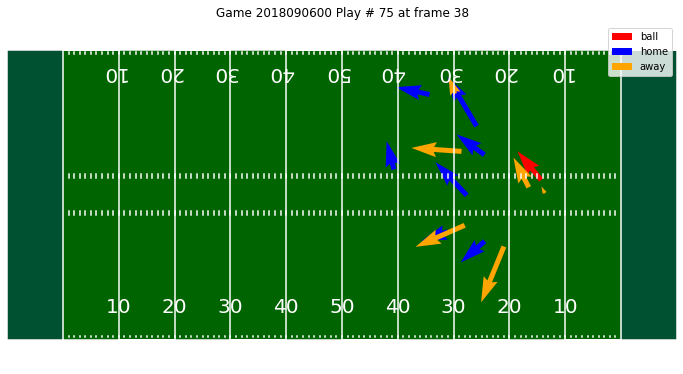

In [296]:
plot_ff_quiver(week1, 2018090600, 75, 38)

In [287]:
def plot_ff_quiver_plotly(df, gameid, playid, frameid):
    away = df[(df['gameId'] == gameid)&(df['team'] == 'away')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    home = df[(df['gameId'] == gameid)&(df['team'] == 'home')&(df['playId'] == playid)&(df['frameId'] == frameid)]
    ball = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(week1['frameId'] == frameid)]

    away_next = df[(df['gameId'] == gameid)&(df['team'] == 'away')&(df['playId'] == playid)&(df['frameId'] == frameid+1)]
    home_next = df[(df['gameId'] == gameid)&(df['team'] == 'home')&(df['playId'] == playid)&(df['frameId'] == frameid+1)]
    ball_next = df[(df['gameId'] == gameid)&(df['displayName'] == 'Football')&(df['playId'] == playid)&(week1['frameId'] == frameid+1)]
    
    awayx = away.loc[:,'x']
    awayy = away.loc[:, 'y']
    awayu = away_next.loc[:,'x'].values - away.loc[:,'x'].values
    awayv = away_next.loc[:,'y'].values - away.loc[:,'y'].values
    #ax.quiver(ball.loc[:,'x'], ball.loc[:,'y'], (ball_next.loc[:,'x'].values - ball.loc[:,'x'].values), (ball_next.loc[:, 'y'].values - ball.loc[:,'y'].values), color = 'red', scale_units = 'xy', label = "ball")
    #ax.quiver(home.loc[:,'x'], home.loc[:,'y'], (home_next.loc[:,'x'].values - home.loc[:,'x'].values), (home_next.loc[:,'y'].values - home.loc[:,'y'].values), color = 'blue', scale_units = 'xy', label = "home")
    #ax.quiver(away.loc[:,'x'], away.loc[:,'y'], (away_next.loc[:,'x'].values - away.loc[:,'x'].values), (away_next.loc[:,'y'].values - away.loc[:,'y'].values), color = 'orange', scale_units = 'xy', label = "away")
    fig = ff.create_quiver(awayx, awayy, awayu, awayv, scale = 1, arrow_scale = 0.4)

    fig.show()

In [286]:
plot_ff_quiver_plotly(week1, 2018090600, 75, 38)

## Additional Questions/Items

In [22]:
#Does player performance decrease as the season goes on?
#   How do you define defensive performance and its increase/decrease?

#What are coverage schemes (man, zone, etc) that the defense employs? What coverage options tend to be better performing?
#   Better performing = no completion, no gain. Fourth down incompletion. Interceptions.

#Which players are the best at closely tracking receivers as they try to get open?
#   Height, weight, age, schools, teams, proximity to offensive player. How do you define "open" in your program?

#Which players are the best at closing on receivers when the ball is in the air?
#   Height, weight, age, schools, teams, proximity to offensive player

#Which players are the best at defending pass plays when the ball arrives?
#   Height, weight, age, schools, teams

#Is there any way to use player tracking data to predict whether or not certain penalties – for example, defensive pass interference – will be called?
#   Movement, formation, adjustments, orientations, player IDs, home/away

#Who are the NFL’s best players against the pass?
#   Most interceptions, blocks?

#How does a defense react to certain types of offensive plays?
#   Movement, formation, adjustments

#Is there anything about a player – for example, their height, weight, experience, speed, or position – that can be used to predict their performance on defense?
#   How do you measure performance on defense?

#Are there favorable matchups to specific QBs/profiles of QBs/offensive lineups?
#   Physical features of all players in offensive lineup and defensive lineup, result of play